In [ ]:
!pip install -q torchvision matplotlib

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.5 MB/s eta 0:00:00


Saving healthy.zip to healthy.zip
Archive:  healthy.zip
   creating: ./healthy_dataset/healthy/
  inflating: ./healthy_dataset/healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG  
  inflating: ./healthy_dataset/healthy/03da9931-e514-4cc7-b04a-8f474a133ce5___RS_HL 1830.JPG  
  inflating: ./healthy_dataset/healthy/04481ca2-f94c-457e-b785-1ac05800b7ec___RS_HL 1930.JPG  
  inflating: ./healthy_dataset/healthy/046641c1-f837-49eb-b5f2-4109910a027c___RS_HL 1878.JPG  
  inflating: ./healthy_dataset/healthy/07dfb451-4378-49d1-b699-33a5fc49ff07___RS_HL 5399.JPG  
  inflating: ./healthy_dataset/healthy/0b3e5032-8ae8-49ac-8157-a1cac3df01dd___RS_HL 1817.JPG  
  inflating: ./healthy_dataset/healthy/0be9d721-82f5-42c3-b535-7494afe01dbe___RS_HL 1814.JPG  
  inflating: ./healthy_dataset/healthy/0f4ebc5a-d646-436a-919d-961342997cde___RS_HL 4183.JPG  
  inflating: ./healthy_dataset/healthy/1106c3fc-92cb-41a6-a6c6-8f08b9b45108___RS_HL 1914.JPG  
  inflating: ./healthy_dataset/healthy/111cd9d8-4

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


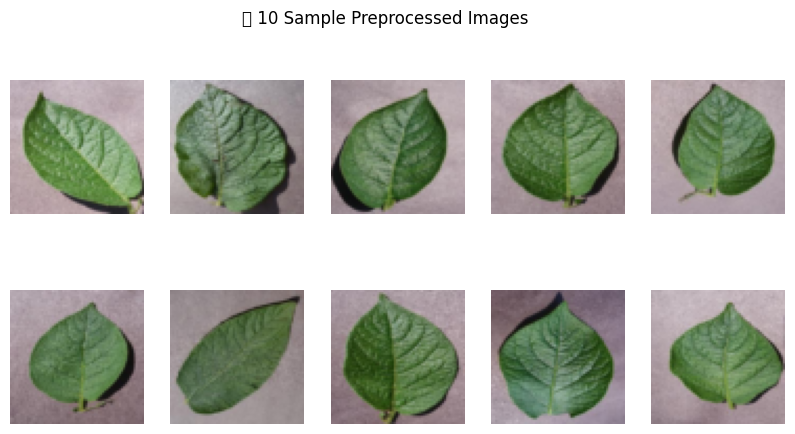

In [ ]:
# Upload and unzip
from google.colab import files
uploaded = files.upload()  # Upload the healthy dataset zip here
!unzip -o "*.zip" -d ./healthy_dataset/

# Image Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

# Custom Dataset that searches all subdirectories
class HealthyDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.transform = transform
        self.image_paths = []

        valid_exts = ('.jpg', '.jpeg', '.png', '.bmp')
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.lower().endswith(valid_exts):
                    self.image_paths.append(os.path.join(root, file))

        if len(self.image_paths) == 0:
            raise ValueError(f"No valid images found in directory {image_dir} or its subfolders.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Load dataset and visualize samples
image_dir = './healthy_dataset/'
dataset = HealthyDataset(image_dir, transform)
print(f"✅ Total images found: {len(dataset)}")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Show 10 sample preprocessed images
sample_batch = next(iter(dataloader))
plt.figure(figsize=(10, 5))
for i in range(10):
    img = sample_batch[i].permute(1, 2, 0).numpy()
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.suptitle("✅ 10 Sample Preprocessed Images")
plt.show()


In [ ]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256*8*8, latent_dim)
        self.fc_logvar = nn.Linear(256*8*8, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Reparameterization Trick
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

# Generator / Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 256*8*8)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(z.size(0), 256, 8, 8)
        return self.deconv(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256*8*8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128

encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_enc = optim.Adam(encoder.parameters(), lr=1e-4)
optimizer_dec = optim.Adam(decoder.parameters(), lr=1e-4)
optimizer_dis = optim.Adam(discriminator.parameters(), lr=1e-4)

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Function to display images
def show_images(images, title="Generated Images", num_images=10):
    images = images[:num_images]
    grid_img = vutils.make_grid(images, nrow=5, normalize=True)
    plt.figure(figsize=(8, 4))
    plt.axis("off")
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
    plt.show()

# Loss functions
adversarial_loss = nn.BCELoss()
reconstruction_loss_fn = nn.MSELoss()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_E = optim.Adam(vae_encoder.parameters(), lr=0.0001, betas=(0.5, 0.999))

# Function for weight initialization (using Xavier Initialization for better convergence)
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Initialize networks with proper weight initialization
vae_encoder.apply(weights_init)
generator.apply(weights_init)
discriminator.apply(weights_init)

# Training loop
def train(num_epochs=100):  # Increased epochs for better convergence
    start_time = time.time()

    for epoch in range(num_epochs):
        for batch_idx, real_imgs in enumerate(dataloader):
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            # -------- Train VAE Encoder + Generator --------
            optimizer_G.zero_grad()
            optimizer_E.zero_grad()

            # Forward pass through VAE encoder to get latent variables
            mu, logvar = vae_encoder(real_imgs)
            std = torch.exp(0.5 * logvar)
            z = mu + std * torch.randn_like(std)

            # Generator generates images from latent space
            recon_imgs = generator(z)

            # Discriminator classifies generated images
            pred_fake = discriminator(recon_imgs)

            # Losses
            recon_loss = reconstruction_loss_fn(recon_imgs, real_imgs)
            adv_loss = adversarial_loss(pred_fake, valid)
            kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / batch_size

            g_loss = recon_loss + adv_loss + kld
            g_loss.backward()
            optimizer_G.step()
            optimizer_E.step()

            # -------- Train Discriminator --------
            optimizer_D.zero_grad()
            pred_real = discriminator(real_imgs)
            loss_real = adversarial_loss(pred_real, valid)

            pred_fake = discriminator(recon_imgs.detach())
            loss_fake = adversarial_loss(pred_fake, fake)

            d_loss = 0.5 * (loss_real + loss_fake)
            d_loss.backward()
            optimizer_D.step()

        # Epoch Summary
        print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

        # Display 10 generated images after each epoch
        with torch.no_grad():
            z_sample = torch.randn(10, latent_dim).to(device)
            gen_images = generator(z_sample)
            show_images(gen_images.cpu(), f"Generated Images after Epoch {epoch+1}")

    end_time = time.time()
    print(f"\n✅ Training completed in {end_time - start_time:.2f} seconds.")

# Run training for more epochs (up to 100) to get better quality
train(num_epochs=100)


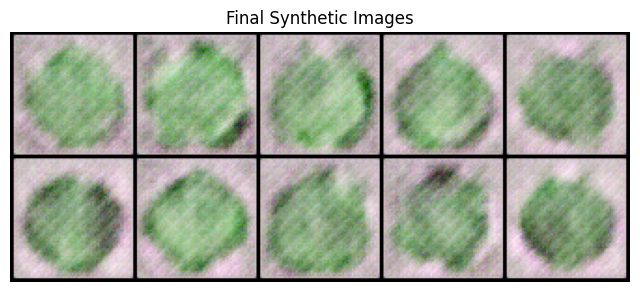

✅ All 50 synthetic images saved in 'synthetic_outputs' folder.


In [ ]:
import os

# Directory to save synthetic images
os.makedirs("synthetic_outputs", exist_ok=True)

# Generate 50 synthetic images
generator.eval()
with torch.no_grad():
    z = torch.randn(50, latent_dim).to(device)
    synthetic_images = generator(z).cpu()

# Show 10 sample synthetic images
show_images(synthetic_images, "Final Synthetic Images")

# Save all 50 images
from torchvision.utils import save_image

for idx, img in enumerate(synthetic_images):
    save_image(img, f"synthetic_outputs/synthetic_{idx+1}.png", normalize=True)

print("✅ All 50 synthetic images saved in 'synthetic_outputs' folder.")
